In [36]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pandas as pd
TOP_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
if TOP_DIR not in sys.path:
    sys.path.insert(0, TOP_DIR)
from causalsent.constants import CAUSALSENT_DIR, CITING_ID_COL, CITED_ID_COL, NEGATIVE_ID_COL, CORPUS_ID_COL
from causalsent.data.utils import load_imdb_data, load_civil_comments_data
from causalsent.data.generators import IMDBDataset, CivilCommentsDataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from causalsent.utils import save_model, get_default_sent_training_args, seed_everything
from pprint import pprint
seed_everything(328)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set hyperparameters + combine with default args

In [37]:
sys.argv = [
    'notebook',
    '--limit_data', '500',
    '--max_seq_length', '150',
    '--lr', '5e-5',
    '--treatment_phrase', 'love',
    '--lambda_bce', '1.0',
    '--lambda_reg', '0.001',
    '--lambda_riesz', '0.01',
    '--dataset', 'imdb',
    '--log_every', '5',
    #'--running_ate',
    #'--estimate_targets_for_ate',
]
args = get_default_sent_training_args(regime = 'causal_sent')

Selecting dataset for sentiment task (IMDB or CivilComments)...
Setting hyperparameters for sentiment task...


# Load Data

In [38]:
imdb_train_original = load_imdb_data(split = "train")
imdb_train_splits = imdb_train_original.train_test_split(test_size=0.2)
imdb_train = imdb_train_splits["train"]
imdb_val = imdb_train_splits["test"]

In [39]:
imdb_train['text'][0:2]

["PROBLEM CHILD is one of the worst movies I have seen in the last decade! This is a bad movie about a savage boy adopted by two parents, but he gets into trouble later. That Junior can drive Grandpa's car. He can scare people with a bear. He can put a room on fire! It is a bad movie as much as BATTLEFIELD EARTH. A sequel is an even worse fate. Rent CHICKEN RUN instead.<br /><br />*1/2 out of **** I give it.",
 'Along with Patrick McGoohan and Robert Culp, Jack Cassidy was an iconic Columbo villain. The very first "proper" episode of Columbo, following two standalone pilots, "Murder By The Book" is not far off classic status.<br /><br />Jack Cassidy plays Ken Franklin, one half of a murder mystery writing partnership. His partner Jim is the talented one, whereas Ken has no talent other than the gift of the gab and a skill for promoting the books. As soon as Jim has decided he no longer requires Ken\'s marketing skills, Ken hatches a plot to kill Jim. Except it\'s not a new plot, it\'s 

# EDA of IMDB

In [40]:
import pandas as pd
import random
from IPython.display import display, HTML

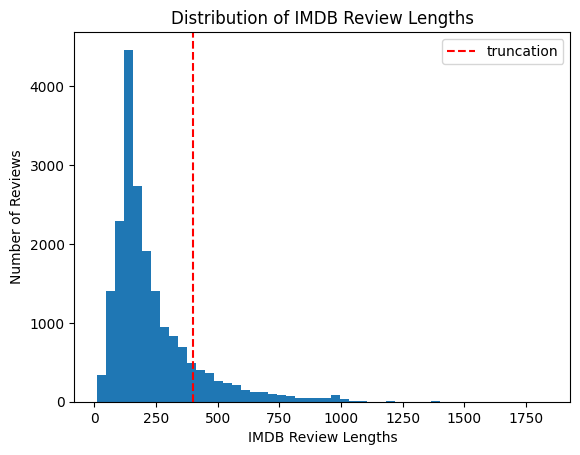

In [41]:
# plot distribution of text lengths in imdb_train 
# add cutoff at 150 words labeled "truncation"

imdb_train_df = pd.DataFrame(imdb_train)

text_lengths = imdb_train_df['text'].apply(lambda x: len(x.split()))
plt.axvline(400, color='red', linestyle='--', label='truncation')
plt.hist(text_lengths, bins=50)
plt.xlabel('IMDB Review Lengths')
plt.ylabel('Number of Reviews')
plt.title('Distribution of IMDB Review Lengths')
plt.legend()



### Compare Civil Comments Lengths

Filter: 100%|██████████| 1804874/1804874 [00:37<00:00, 47597.31 examples/s]


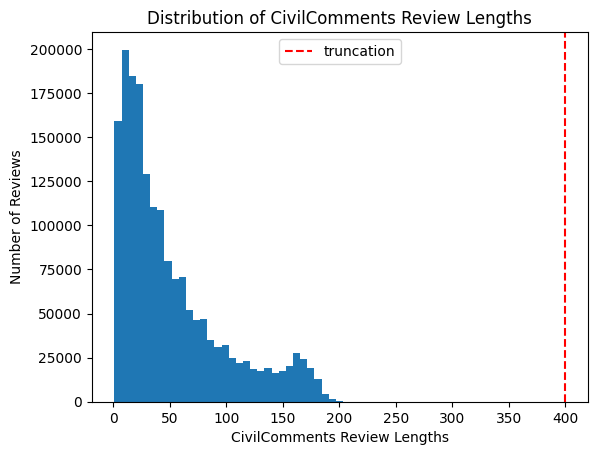

Number of toxic comments: 540110 out of 1804874 total comments


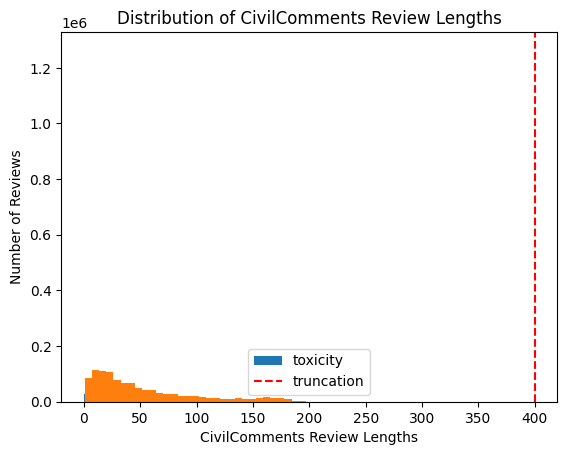

Number of toxic comments: 540110 out of 1080220 total comments


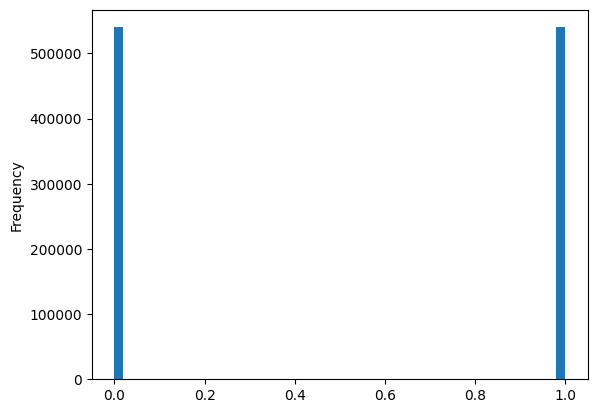

In [51]:
# plot distribution of text lengths in imdb_train 
# add cutoff at 150 words labeled "truncation"
civil_train_raw = load_civil_comments_data(split = "train", binarize = False, balance = False)
civil_train_raw = pd.DataFrame(civil_train_raw)
civil_train_proc = load_civil_comments_data(split = "train", binarize = True, balance = True)
civil_train_proc = pd.DataFrame(civil_train_proc)

for civil_train in [civil_train_raw, civil_train_proc]:
    text_lengths = civil_train['text'].apply(lambda x: len(x.split()))
    plt.axvline(400, color='red', linestyle='--', label='truncation')
    plt.hist(text_lengths, bins=50)
    plt.xlabel('CivilComments Review Lengths')
    plt.ylabel('Number of Reviews')
    plt.title('Distribution of CivilComments Review Lengths')
    plt.legend()
    plt.show()
    
    civil_train['toxicity'].plot.hist(bins=50)
    
    nonzero = len(civil_train[civil_train['toxicity'] > 0])
    total = len(civil_train)
    print(f"Number of toxic comments: {nonzero} out of {total} total comments")

In [45]:
imdb_train = pd.DataFrame(imdb_train)

treatment_phrase = "love"
max_length_display = 15  # Max number of words to display around the treatment phrase

# Find examples where the treatment phrase appears
treatment_phrase_indices = [
    i for i, text in enumerate(imdb_train['text']) if treatment_phrase.lower() in text.lower()
]

# Split into positive and negative examples
positive_indices = [
    idx for idx in treatment_phrase_indices if imdb_train.loc[idx, 'label'] == 1
]
negative_indices = [
    idx for idx in treatment_phrase_indices if imdb_train.loc[idx, 'label'] == 0
]

# compute percent of positive examples in treatment phrase examples
percent_positive_treated = len(positive_indices) / len(treatment_phrase_indices) * 100
# compute percent of positive examples in untreated (opposite of treatment_phrase_indices) examples

untreated_indices = [
    i for i, text in enumerate(imdb_train['text']) if treatment_phrase.lower() not in text.lower()
]
percent_positive_untreated = sum(imdb_train.loc[untreated_indices, 'label']) / len(untreated_indices) * 100

print(f"Percent of positive examples in examples with the treatment phrase: {percent_positive_treated:.2f}%")
print(f"Percent of positive examples in untreated examples: {percent_positive_untreated:.2f}%")

print(f"Correlation based (confounded) effect = E_n[Y|T=1] - E_n[Y|T=0] = Pr[Y|T=1] - Pr[Y|T=0] = {percent_positive_treated - percent_positive_untreated:.2f}%")

# Randomly sample 2 from each, or fewer if not enough examples are available
sampled_positive_indices = random.sample(
    positive_indices, min(4, len(positive_indices))
)
sampled_negative_indices = random.sample(
    negative_indices, min(4, len(negative_indices))
)

# Combine sampled indices
random_indices = sampled_positive_indices + sampled_negative_indices

# Highlight and truncate text
def highlight_and_truncate(text, phrase, max_words):
    words = text.split()
    highlighted_snippets = []
    
    for i, word in enumerate(words):
        if phrase.lower() in word.lower():
            # Start and end indices for the snippet
            start = max(0, i - max_words // 2)
            end = min(len(words), i + max_words // 2 + 1)
            snippet = words[start:end]
            snippet = ' '.join(snippet).replace(phrase, f"<b style='color:red;'>{phrase}</b>")
            highlighted_snippets.append(f"... {snippet} ...")
    
    # Join all snippets
    return ' '.join(highlighted_snippets)

# Prepare data for display
display_data = []
for idx in random_indices:
    text = imdb_train.loc[idx, 'text']
    label = imdb_train.loc[idx, 'label']
    highlighted_text = highlight_and_truncate(text, treatment_phrase, max_length_display)
    display_data.append((highlighted_text, label))

# Create a pretty table
table_html = "<table style='border-collapse: collapse; width: 100%;'>"
table_html += """
<thead style='color:lightgray; font-weight:bold;'>
    <tr>
        <th style='padding: 8px;'>Highlighted Text</th>
        <th style='padding: 8px;'>Label</th>
    </tr>
</thead>
"""

for text, label in display_data:
    table_html += f"""
    <tr>
        <td style='padding: 8px; border: 1px solid #ddd;'>{text}</td>
        <td style='padding: 8px; border: 1px solid #ddd; text-align: center;'>{label}</td>
    </tr>
    """

table_html += "</table>"

# Display the table
display(HTML(table_html))

Percent of positive examples in examples with the treatment phrase: 63.80%
Percent of positive examples in untreated examples: 45.38%
Correlation based (confounded) effect = E_n[Y|T=1] - E_n[Y|T=0] = Pr[Y|T=1] - Pr[Y|T=0] = 18.41%


Highlighted Text,Label
... evident will to nurture him into their beloved practise and hopefully become a good role ...,1
... image more dramatically. A great success in Love Actually and as Lizie in Jane Austen's ...,1
... meets a beautiful girl and falls in love so things get even more complicated for ...,1
"... film, and it's one of his most beloved of all time. Initially a box office ... ... climactic showdown ""the world cannot live without love"" as opposed to the original ""you can't ...",1
"... that somewhere in LA is his reincarnated lover and gives him a junk piece of ... ... the Balls.so Sarah, the reincarnated lover, has her own flashbacks. I have the ... ... satisfying dragon on Helicopter battle my cruel lover Dwar treats me to a pi$$ and ... ... out of nowhere and the snakes wrestle/make love whatever. And i'm not kidding good snake ... ... Patrick Dempsey""ish"".The one thing i love about this filthy prostitute Dwars is its ...",0
"... Having seen the trailer, and being a thriller-lover, I expected to see first of all ...",0
"... Let me just say I loved the original Boogeyman. Sure, it's a flawed ...",0
"... stars on screen or even if you love to watch sequels, even if they are ...",0


In [46]:
len([x for x in imdb_train['text'] if not x])

0

In [47]:
imdb_train_original['text'][0:2]

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

In [48]:
if args.dataset == "imdb":
    imdb_train_original = load_imdb_data(split = "train")
    imdb_train_splits = imdb_train_original.train_test_split(test_size=0.2)
    imdb_train = imdb_train_splits["train"]
    imdb_val = imdb_train_splits["test"]
    
    print(type(imdb_train))
    print(imdb_train)

    imdb_ds_train: IMDBDataset = IMDBDataset(imdb_train, 
                                    split="train",
                                    args=args)
    imdb_ds_val: IMDBDataset = IMDBDataset(imdb_val,
                                        split = "validation", 
                                        args = args)
    ds_train = imdb_ds_train
    ds_val = imdb_ds_val
else: 
    civil_train = load_civil_comments_data(split = "train")
    civil_val = load_civil_comments_data(split = "test")
    
    civil_ds_train: CivilCommentsDataset = CivilCommentsDataset(civil_train, 
                                                split="train",
                                                args=args)
    civil_ds_val: CivilCommentsDataset = CivilCommentsDataset(civil_val,
                                                split = "validation", 
                                                args = args)
    ds_train = civil_ds_train
    ds_val = civil_ds_val

<class 'datasets.arrow_dataset.Dataset'>
Dataset({
    features: ['text', 'label'],
    num_rows: 20000
})
Limiting data to 500 rows.
Creating treated and control counterfactuals...
Tokenizing texts for real, treated, and control counterfactuals...
Truncating texts during tokenization to length: 150


Tokenizing texts: 100%|██████████| 500/500 [00:00<00:00, 1877.24it/s]


Truncating texts during tokenization to length: 150


Tokenizing texts: 100%|██████████| 500/500 [00:00<00:00, 301748.49it/s]


Truncating texts during tokenization to length: 150


Tokenizing texts: 100%|██████████| 500/500 [00:00<00:00, 140334.05it/s]


Limiting data to 500 rows.
Tokenizing texts for real, treated, and control counterfactuals...
Truncating texts during tokenization to length: 150


Tokenizing texts: 100%|██████████| 500/500 [00:00<00:00, 3057.13it/s]


In [49]:
# print(f"Train Dataset size: {len(ds_train)}")
# print("Example train data point:")
# example = ds_train[0]
# pprint(example)
# 
# print() 
# 
# print(f"Val Dataset size: {len(ds_val)}")
# print("Example val data point:")
# example = ds_val[0]
# pprint(example)

In [50]:
# targets = [d['target'] for d in ds_train]
# plt.figure(figsize=(8, 6))
# plt.hist(targets, bins=20, edgecolor='black', alpha=0.7)
# plt.title("Histogram of Target Values in Train Dataset")
# plt.xlabel("Target Value")
# plt.ylabel("Frequency")
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()